In [2]:
# Video 129: https://youtu.be/wkwtIeq9Ljo
# Video 130: https://youtu.be/MSjW3qyw7H0
#Video 131: https://youtu.be/4umFSRPx-94

"""
@author: Sreenivas Bhattiprolu
Dataset from: https://lhncbc.nlm.nih.gov/publication/pub9932
"""
from matplotlib import pyplot as plt
from keras_preprocessing.image import ImageDataGenerator, img_to_array

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Prepare Data

# The data
###### cells infected with malaria and cells not infected with malaria.
###### cells infected with malaria
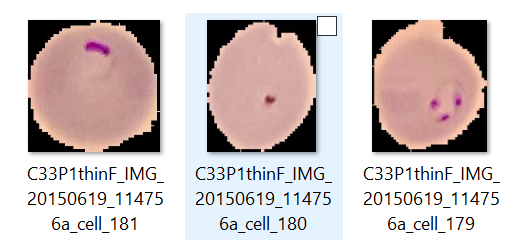
###### cells not infected with malaria
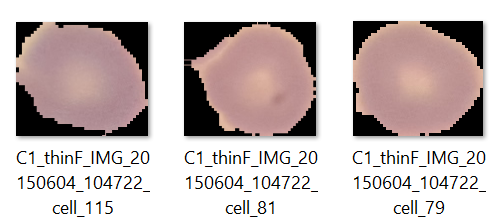

In [3]:
#!unzip "/content/gdrive/MyDrive/ml/GIT_datasets/cell_images_full.zip" -d "/content/cell_images/"

Streaming output truncated to the last 5000 lines.
 extracting: /content/cell_images/cell_images_full/cell_images/Uninfected/C71P32_ThinF_IMG_20150813_162016_cell_61.png  
 extracting: /content/cell_images/cell_images_full/cell_images/Uninfected/C71P32_ThinF_IMG_20150813_162016_cell_72.png  
 extracting: /content/cell_images/cell_images_full/cell_images/Uninfected/C71P32_ThinF_IMG_20150813_162016_cell_80.png  
 extracting: /content/cell_images/cell_images_full/cell_images/Uninfected/C71P32_ThinF_IMG_20150813_162016_cell_82.png  
 extracting: /content/cell_images/cell_images_full/cell_images/Uninfected/C71P32_ThinF_IMG_20150813_162146_cell_120.png  
 extracting: /content/cell_images/cell_images_full/cell_images/Uninfected/C71P32_ThinF_IMG_20150813_162146_cell_121.png  
 extracting: /content/cell_images/cell_images_full/cell_images/Uninfected/C71P32_ThinF_IMG_20150813_162146_cell_134.png  
 extracting: /content/cell_images/cell_images_full/cell_images/Uninfected/C71P32_ThinF_IMG_20150813

In [3]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='constant')  #Try other fill modes, e.g. nearest, reflect, wrap

In [5]:
batch_size = 16
#Let's prepare our data. We will use .flow_from_directory() 
#to generate batches of image data (and their labels) 
#directly from our png in their respective folders.

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for validation:
# only rescaling. But you can try other operations
validation_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '/content/cell_images/cell_images_full/cell_images',  # this is the input directory
        target_size=(150, 150),  # all images will be resized to 64x64
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = validation_datagen.flow_from_directory(
        '/content/cell_images/cell_images_full/cell_validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 24525 images belonging to 2 classes.
Found 3033 images belonging to 2 classes.


# Make model

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
#from keras import backend as K


SIZE = 150
###2 conv and pool layers. with some normalization and drops in between.

INPUT_SHAPE = (SIZE, SIZE, 3)   #change to (SIZE, SIZE, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())    

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                    

# Add Callbacks, e.g. ModelCheckpoints, earlystopping, csvlogger

In [19]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

#ModelCheckpoint callback saves a model at some interval. 
filepath="/content/saved_models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5" #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss. 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('my_logs.csv', separator=',', append=False)

callbacks_list = [checkpoint, early_stop, log_csv]

#We can now use these generators to train our model. 
#Give this a name so we can call it later for plotting loss, accuracy etc. as a function of epochs.
history = model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,    #The 2 slashes division return rounded integer
        epochs=5,
        validation_data=validation_generator,
        validation_steps=800 // batch_size,
        callbacks=callbacks_list)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


125/125 [==============================] - ETA: 0s - loss: 0.2200 - accuracy: 0.9380
Epoch 1: val_accuracy improved from -inf to 0.87875, saving model to /content/saved_models/weights-improvement-01-0.88.hdf5
125/125 [==============================] - 12s 96ms/step - loss: 0.2200 - accuracy: 0.9380 - val_loss: 0.4389 - val_accuracy: 0.8788
Epoch 2/5
125/125 [==============================] - ETA: 0s - loss: 0.2442 - accuracy: 0.9225
Epoch 2: val_accuracy improved from 0.87875 to 0.90375, saving model to /content/saved_models/weights-improvement-02-0.90.hdf5
125/125 [==============================] - 12s 93ms/step - loss: 0.2442 - accuracy: 0.9225 - val_loss: 0.2799 - val_accuracy: 0.9038
Epoch 3/5
125/125 [==============================] - ETA: 0s - loss: 0.2314 - accuracy: 0.9305
Epoch 3: val_accuracy did not improve from 0.90375
125/125 [==============================] - 11s 92ms/step - loss: 0.2314 - accuracy: 0.9305 - val_loss: 0.3439 - val_accuracy: 0.8900
Epoch 4/5
125/125 [=====

In [20]:
model.save('malaria_augmented_model.h5')  # always save your weights after training or during training

# Evaluating the model

In [21]:
train_loss, train_acc = model.evaluate_generator(train_generator, steps=16)
validation_loss, test_acc = model.evaluate_generator(validation_generator, steps=16)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


Train: 0.965, Test: 0.922


Values stored in history are ... 
 {'loss': [0.21997663378715515, 0.24416175484657288, 0.23137687146663666, 0.22110481560230255, 0.218755304813385], 'accuracy': [0.9380000233650208, 0.9225000143051147, 0.9304999709129333, 0.9319999814033508, 0.9380000233650208], 'val_loss': [0.4388979971408844, 0.2798866033554077, 0.3439196050167084, 0.27795979380607605, 0.24836158752441406], 'val_accuracy': [0.8787500262260437, 0.9037500023841858, 0.8899999856948853, 0.8974999785423279, 0.9175000190734863]}


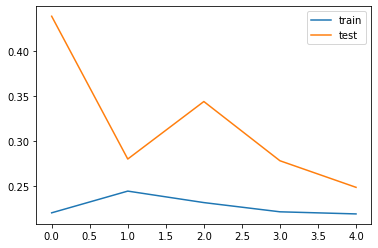

In [22]:
# plot training history
print("Values stored in history are ... \n", history.history)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


# Continue training, by modifying weights to existing model

In [23]:
#The saved model can be reinstated.
from keras.models import load_model
new_model = load_model('malaria_augmented_model.h5')
results = new_model.evaluate_generator(validation_generator, steps=16)
print(" validation loss and accuracy are", results)
history_new_model = new_model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,    #The 2 slashes division return rounded integer
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800 // batch_size,
        callbacks=callbacks_list)
model.save('malaria_augmented_model_updated.h5') 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


 validation loss and accuracy are [0.22761321067810059, 0.91796875]
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


125/125 [==============================] - ETA: 0s - loss: 0.2367 - accuracy: 0.9345
Epoch 1: val_accuracy did not improve from 0.91750
125/125 [==============================] - 12s 93ms/step - loss: 0.2367 - accuracy: 0.9345 - val_loss: 0.5850 - val_accuracy: 0.8438
Epoch 2/50
125/125 [==============================] - ETA: 0s - loss: 0.1943 - accuracy: 0.9465
Epoch 2: val_accuracy did not improve from 0.91750
125/125 [==============================] - 12s 96ms/step - loss: 0.1943 - accuracy: 0.9465 - val_loss: 0.3125 - val_accuracy: 0.9000
Epoch 3/50
125/125 [==============================] - ETA: 0s - loss: 0.2068 - accuracy: 0.9395
Epoch 3: val_accuracy did not improve from 0.91750
125/125 [==============================] - 11s 91ms/step - loss: 0.2068 - accuracy: 0.9395 - val_loss: 0.2826 - val_accuracy: 0.8975
Epoch 4/50
125/125 [==============================] - ETA: 0s - loss: 0.1765 - accuracy: 0.9490
Epoch 4: val_accuracy did not improve from 0.91750
125/125 [===============

Values stored in history are ... 
 {'loss': [0.2367429882287979, 0.1942911297082901, 0.20677781105041504, 0.17653578519821167, 0.20902809500694275, 0.2139020413160324, 0.2433805763721466, 0.21545858681201935, 0.23364564776420593, 0.22260203957557678, 0.20642603933811188, 0.23723460733890533, 0.2552928030490875, 0.24785983562469482, 0.2369929552078247, 0.23654115200042725, 0.251799076795578, 0.2181878685951233, 0.2071567326784134, 0.36387479305267334, 0.2772260308265686, 0.22311636805534363, 0.2522231340408325, 0.2930610775947571, 0.22069799900054932, 0.2599525451660156, 0.25090330839157104, 0.2710305154323578, 0.24962112307548523, 0.3272205889225006, 0.21648000180721283, 0.36796027421951294, 0.2773253619670868, 0.22530004382133484, 0.2375568151473999, 0.2535656988620758, 0.24941116571426392, 0.2640627324581146, 0.41798990964889526, 0.27624139189720154, 0.30222752690315247, 0.2988108694553375, 0.18417340517044067, 0.19531390070915222, 0.2886107861995697, 0.3225363790988922, 0.3201411962

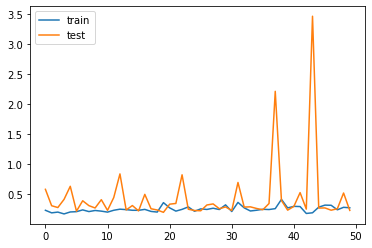

In [24]:
# plot training history
print("Values stored in history are ... \n", history_new_model.history)
plt.plot(history_new_model.history['loss'], label='train')
plt.plot(history_new_model.history['val_loss'], label='test')
plt.legend()
plt.show()


Values stored in history are ... 
 {'loss': [0.2367429882287979, 0.1942911297082901, 0.20677781105041504, 0.17653578519821167, 0.20902809500694275, 0.2139020413160324, 0.2433805763721466, 0.21545858681201935, 0.23364564776420593, 0.22260203957557678, 0.20642603933811188, 0.23723460733890533, 0.2552928030490875, 0.24785983562469482, 0.2369929552078247, 0.23654115200042725, 0.251799076795578, 0.2181878685951233, 0.2071567326784134, 0.36387479305267334, 0.2772260308265686, 0.22311636805534363, 0.2522231340408325, 0.2930610775947571, 0.22069799900054932, 0.2599525451660156, 0.25090330839157104, 0.2710305154323578, 0.24962112307548523, 0.3272205889225006, 0.21648000180721283, 0.36796027421951294, 0.2773253619670868, 0.22530004382133484, 0.2375568151473999, 0.2535656988620758, 0.24941116571426392, 0.2640627324581146, 0.41798990964889526, 0.27624139189720154, 0.30222752690315247, 0.2988108694553375, 0.18417340517044067, 0.19531390070915222, 0.2886107861995697, 0.3225363790988922, 0.3201411962

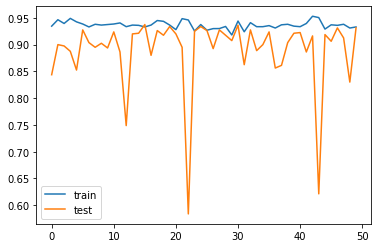

In [25]:
# plot training history
print("Values stored in history are ... \n", history_new_model.history)
plt.plot(history_new_model.history['accuracy'], label='train')
plt.plot(history_new_model.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [26]:
model.save('malaria_augmented_model_updated.h5') 